In [1]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate
from sklearn.metrics import *

from tools import helpers as h

from scipy.stats import norm

%matplotlib inline
import matplotlib.pyplot as plt

### Read in Louvain Subclusters

In [2]:
louv = pd.read_csv('../data/cluster/louvain_clusters.txt', index_col=0, sep='\t')
louv.columns = ['cluster_super']
louv = louv.merge(pd.read_csv('../data/cluster/louvain_small_clusters.txt', index_col=0, sep='\t'), left_index=True, right_index=True)
louv.columns = ['cluster_super', 'cluster_sub']
louv.head()

,cluster_super,cluster_sub
names,,
MST1R,3,11
YES1,3,11
TYRO3,3,11
FGR,3,11
SRC,3,11


### Get the HGNC Mapper

In [3]:
hgnc_mapper = h.fetch_hgnc_mapper()

In [4]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    def splitListToRows(row,row_accumulator,target_column,separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)
    new_rows = []
    df.apply(splitListToRows,axis=1,args = (new_rows,target_column,separator))
    new_df = pd.DataFrame(new_rows)
    return new_df

### Klaeger Science Data

In [5]:
# initial target list -- not for linear programming
klaeger = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 2 Target Lists.xlsx', sheet_name='Kinobeads')

# a number of drugs have very similar targets listed in the same row
# we parse to separate these out 
klaeger = splitDataFrameList(klaeger, 'Gene Name', ';')
# filter to only hgnc keys
klaeger = klaeger[klaeger['Gene Name'].isin(hgnc_mapper.keys())]

# convert to hgnc
klaeger['Gene Name'] = klaeger['Gene Name'].apply(lambda x: hgnc_mapper[x])

# filter to our kinases
klaeger = klaeger[klaeger['Gene Name'].isin(set(louv.index))]

# lower drug names
klaeger['Drug'] = [x.lower().replace('-', '') for x in klaeger.Drug]

klaeger.head()

,Apparent Kd,BIC,Beads,Bottom,Correction Factor,DMSO Intensity,Drug,EC50,EC50 Standard Error,Gene Name,...,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM,Relative Intensity DMSO,Slope,Target Classification,Top
0,101.828368,-20.503519,Kinobeads,0.009092,0.673073,136300000,abemaciclib,151.288760,45.696999,AAK1,...,0.181984,0.905556,0.738292,0.323354,0.063421,0.057103,1,0.773714,High confidence,0.957905
1,39.805937,-12.606135,Kinobeads,-0.001200,0.622595,10460000,abemaciclib,63.935536,68.832970,ADCK1,...,0.000000,1.045974,1.141565,0.000000,0.000000,0.000000,1,12.051439,High confidence,1.014355
2,56031.642989,-15.330485,Kinobeads,-1.003278,0.660952,72050000,abemaciclib,84774.108960,217756.243215,BMP2K,...,0.885498,1.101696,1.087891,0.863230,0.862572,0.313434,1,0.603088,High confidence,1.034558
3,19.447883,-22.486948,Kinobeads,0.018690,0.203913,888660000,abemaciclib,95.373379,12.131433,CAMK2D,...,0.021331,0.894551,0.900583,0.178266,0.004220,0.017424,1,1.774882,High confidence,0.972850
4,17.889794,1.734623,Kinobeads,0.043265,0.217204,266400000,abemaciclib,82.363844,NaN,CAMK2G,...,0.013431,1.125435,1.236451,0.139777,0.005382,0.017473,1,6.255996,High confidence,1.232332


In [6]:
len(set(klaeger.Drug))

220

In [7]:
len(set(klaeger['Gene Name']))

247

In [8]:
raw_conc_data = klaeger[['Drug', 'Gene Name'] + [x for x in klaeger.columns if 'Relative Intensity' in x and 'DMSO' not in x]]
raw_conc_data.head()

,Drug,Gene Name,Relative Intensity 10 nM,Relative Intensity 100 nM,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
0,abemaciclib,AAK1,0.791054,0.639565,0.181984,0.905556,0.738292,0.323354,0.063421,0.057103
1,abemaciclib,ADCK1,0.869866,0.000000,0.000000,1.045974,1.141565,0.000000,0.000000,0.000000
2,abemaciclib,BMP2K,1.012297,0.973740,0.885498,1.101696,1.087891,0.863230,0.862572,0.313434
3,abemaciclib,CAMK2D,0.984481,0.440384,0.021331,0.894551,0.900583,0.178266,0.004220,0.017424
4,abemaciclib,CAMK2G,1.565245,0.315507,0.013431,1.125435,1.236451,0.139777,0.005382,0.017473


In [9]:
from numba import jit

#@jit()
def gr(conc, GRinf, GR50, GR_Hill_Coeff):
    return GRinf + np.divide(1- GRinf, 1 + np.power(np.divide(conc,GR50+1.e-20), GR_Hill_Coeff)+1.e-20)


def extract_metrics(df, molecule):
    # look for the molecule in the dataframe and extract the relevant items
    return df[df['molecule']==molecule]

### Examine Molecules

In [10]:
agg = pd.read_csv('../data/modelInputs/input_grMetrics.tsv', sep='\t', header=0, index_col=None)

# filter to high r2 values
agg = agg[agg['GR_r2'] > .6]
agg.head()

,molecule,cellline,GR50,GRmax,GRinf,GR_Hill_Coeff,GR_AOC,GR_r2,inf_50,missing_50,normal_50
0,seliciclib,bt20,1.898774,0.194160,-1.00000,1.17820,0.17548,0.97227,0.0,0.0,1.0
1,a443654,bt20,0.051675,-0.492210,-0.63357,0.55758,1.00120,0.98743,0.0,0.0,1.0
3,at7519,bt20,0.186015,-0.401780,-0.40563,1.32240,0.86351,0.99936,0.0,0.0,1.0
4,azd5438,bt20,0.219866,-0.354640,-0.44610,0.79155,0.74810,0.99091,0.0,0.0,1.0
5,azd6482,bt20,0.827110,-0.081485,-0.54825,0.76277,0.42682,0.99881,0.0,0.0,1.0


In [11]:
# filter out nans
agg = agg[agg['GR50'] > 0]

### Begin Merging

In [12]:
display(len(set(agg.molecule)& set(klaeger.Drug)))
display(len(set(agg.molecule) & set(raw_conc_data.Drug)))

82

82

In [13]:
common_drugs = set(agg.molecule) & set(raw_conc_data.Drug)

In [14]:
agg = agg[agg.molecule.isin(common_drugs)]
conc_data = raw_conc_data[raw_conc_data.Drug.isin(common_drugs)]

conc_data.head()

,Drug,Gene Name,Relative Intensity 10 nM,Relative Intensity 100 nM,Relative Intensity 1000 nM,Relative Intensity 3 nM,Relative Intensity 30 nM,Relative Intensity 300 nM,Relative Intensity 3000 nM,Relative Intensity 30000 nM
118,afatinib,ADK,1.486669,1.114982,1.106729,1.101254,1.077845,1.371766,0.704253,0.000000
119,afatinib,EGFR,0.000000,0.000000,0.000000,0.501030,0.000000,0.000000,0.000000,0.000000
120,afatinib,GAK,1.006153,1.015382,0.931173,1.105101,1.025470,1.002719,0.625327,0.203584
122,afatinib,MAPK11,1.081225,1.440432,0.860905,0.929032,1.307298,1.221845,0.741909,0.000000
123,afatinib,MAPK14,1.151929,1.065271,0.814896,1.098158,1.147222,0.968552,0.503224,0.171431


In [15]:
conc_data.shape

(1771, 10)

In [16]:
partial_obs = conc_data.melt(id_vars=['Drug', 'Gene Name'], value_name='Intensity')
partial_obs.head()

,Drug,Gene Name,variable,Intensity
0,afatinib,ADK,Relative Intensity 10 nM,1.486669
1,afatinib,EGFR,Relative Intensity 10 nM,0.000000
2,afatinib,GAK,Relative Intensity 10 nM,1.006153
3,afatinib,MAPK11,Relative Intensity 10 nM,1.081225
4,afatinib,MAPK14,Relative Intensity 10 nM,1.151929


In [17]:
remaining_drugs = list(partial_obs.Drug.unique())
remaining_genes = list(partial_obs['Gene Name'].unique())
intensities_unique = list(partial_obs['variable'].unique())

complete_combos = list(it.product(remaining_drugs, remaining_genes, intensities_unique))
print(len(complete_combos))

152848


In [18]:
complete_obs = pd.DataFrame(complete_combos)
complete_obs[4] = 1
complete_obs.columns=['Drug','Gene Name','Concentration','Intensity']
complete_obs.sort_values(by=['Concentration', 'Drug'], inplace=True)
complete_obs.head(10)

,Drug,Gene Name,Concentration,Intensity
0,afatinib,ADK,Relative Intensity 10 nM,1
8,afatinib,EGFR,Relative Intensity 10 nM,1
16,afatinib,GAK,Relative Intensity 10 nM,1
24,afatinib,MAPK11,Relative Intensity 10 nM,1
32,afatinib,MAPK14,Relative Intensity 10 nM,1
40,afatinib,MAPK9,Relative Intensity 10 nM,1
48,afatinib,MAPKAPK2,Relative Intensity 10 nM,1
56,afatinib,MET,Relative Intensity 10 nM,1
64,afatinib,MYLK,Relative Intensity 10 nM,1
72,afatinib,PHKG2,Relative Intensity 10 nM,1


In [19]:
# fill the observations with known data
# we use a multiindex to slice quickly
complete_obs = complete_obs.groupby(['Drug', 'Gene Name', 'Concentration'])['Intensity'].sum()
partial_obs = partial_obs.groupby(['Drug', 'Gene Name', 'variable'])['Intensity'].sum()

In [20]:
for observation in partial_obs.index:
    complete_obs.loc[observation] = partial_obs[observation]
    
complete_obs = complete_obs.reset_index()
partial_obs = partial_obs.reset_index()

In [21]:
# print the 10 smallest values of intensity to show a good epsilon
list(sorted(complete_obs['Intensity'][complete_obs['Intensity']>0]))[:20]

# extract min
min_observed = min(complete_obs['Intensity'][complete_obs['Intensity']>0])

### Here we translate 0 intensities to a very small intensity

In [22]:
# min_cutter assumes machine precision half of smallest
min_cutter = 2
complete_obs['Intensity'][complete_obs['Intensity'] == 0] = min_observed/min_cutter

/Users/isrobson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# log2 transform the data
complete_obs['Intensity'] = np.log2(complete_obs['Intensity'].values)
complete_obs.head()

,Drug,Gene Name,Concentration,Intensity
0,afatinib,AAK1,Relative Intensity 10 nM,0.0
1,afatinib,AAK1,Relative Intensity 100 nM,0.0
2,afatinib,AAK1,Relative Intensity 1000 nM,0.0
3,afatinib,AAK1,Relative Intensity 3 nM,0.0
4,afatinib,AAK1,Relative Intensity 30 nM,0.0


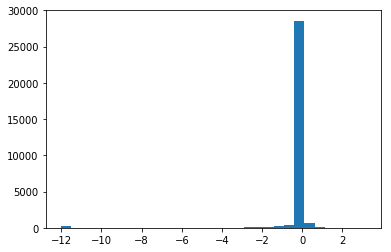

In [24]:
plt.hist(complete_obs.sample(frac=.2)['Intensity'], bins=30)
plt.show()

In [25]:
# first, convert concentration to micromolar (numeric)
complete_obs['Concentration'] = complete_obs['Concentration'].apply(lambda x: float(x.split(' ')[2]))/1000
complete_obs.head()

,Drug,Gene Name,Concentration,Intensity
0,afatinib,AAK1,0.010,0.0
1,afatinib,AAK1,0.100,0.0
2,afatinib,AAK1,1.000,0.0
3,afatinib,AAK1,0.003,0.0
4,afatinib,AAK1,0.030,0.0


### Calculate the growth for each drug x concentration

In [26]:
from time import time
s = time()
interpolated_data = {}
concentrations = list(complete_obs.Concentration.unique())
drugs_pres = complete_obs.Drug.unique()

count = 0
# loop through the observations and create new data
for d in drugs_pres:
    # select observed data
    gr_data_to_interpolate_with = extract_metrics(agg, d)
    
    for i, gr_row in gr_data_to_interpolate_with.iterrows():
        local_gr50, local_grinf, local_grhill, local_cellline = list(gr_row[['GR50', 'GRinf', 'GR_Hill_Coeff', 'cellline']].values)
        
        for c in concentrations:
            interpolated_data[(d, local_cellline, c)] = gr(c, local_grinf, local_gr50, local_grhill)
        
    if count % 10 == 0: 
        print('Done with combo '  + str(count) + '/' + str(len(drugs_pres)))
    count +=1
print(time()-s)

Done with combo 0/82
Done with combo 10/82
Done with combo 20/82
Done with combo 30/82
Done with combo 40/82
Done with combo 50/82
Done with combo 60/82
Done with combo 70/82
Done with combo 80/82
8.401973009109497


In [27]:
interpolated_df = pd.Series(interpolated_data)
interpolated_df.head()

afatinib  hs578t  0.010    0.999997
                  0.100    0.998848
                  1.000    0.674671
                  0.003    1.000000
                  0.030    0.999945
dtype: float64

In [28]:
interpolated_df = pd.DataFrame(interpolated_df)
interpolated_df.head()


0
afatinib hs578t 0.010  0.999997
                0.100  0.998848
                1.000  0.674671
                0.003  1.000000
                0.030  0.999945

In [29]:
interpolated_df = interpolated_df.reset_index()
interpolated_df.columns = ['Drug', 'Cellline', 'Concentration', 'Growth']

In [30]:
interpolated_df['idx'] = interpolated_df['Drug'] + interpolated_df['Concentration'].apply(str)
complete_obs['idx'] = complete_obs['Drug'] + complete_obs['Concentration'].apply(str)

In [31]:
df = interpolated_df.merge(complete_obs, how='left', on='idx')

df = df[['Drug_x', 'Gene Name', 'Cellline', 'Concentration_x', 'Intensity', 'Growth']]
df.columns = ['Drug', 'Gene', 'Cellline', 'Concentration', 'Intensity', 'Growth']
df.head()

,Drug,Gene,Cellline,Concentration,Intensity,Growth
0,afatinib,AAK1,hs578t,0.01,0.0,0.999997
1,afatinib,ABL1,hs578t,0.01,0.0,0.999997
2,afatinib,ABL2,hs578t,0.01,0.0,0.999997
3,afatinib,ACVR1,hs578t,0.01,0.0,0.999997
4,afatinib,ACVR1B,hs578t,0.01,0.0,0.999997


In [32]:
t = df.pivot_table(index=['Drug', 'Cellline', 'Growth', 'Concentration'], columns='Gene')

In [33]:
gene_cols = t.head().reset_index().columns.get_level_values(1).tolist()
gene_cols[:4] = ['Drug', 'Cellline', 'Growth', 'Concentration']

In [34]:
t = t.reset_index()
t.columns = gene_cols

In [35]:
t.shape

(62368, 237)

In [36]:
# standardize the columns
kin_standard_dev = t.std(axis=0)[2:]
t[t.columns[4:]] /= kin_standard_dev

In [37]:
#kin_standard_dev.to_csv('../data/kinase_standard_deviations.csv')

In [38]:
#t.to_csv('../data/target_concentration_data.csv', index=False)

In [39]:
from sklearn.model_selection import train_test_split as tts
#t.to_csv('../data/target_concentration_data.csv', index=False)
t_train, t_test = tts(t, test_size=0.2, random_state=1920)
t_test, t_dev = tts(t_test, test_size=0.5, random_state=1920)

In [40]:
'''t_train.to_csv('../data/modelInputs/standardizedGrowth/train.csv')
t_dev.to_csv('../data/modelInputs/standardizedGrowth/dev.csv')
t_test.to_csv('../data/modelInputs/standardizedGrowth/test.csv')'''

"t_train.to_csv('../data/modelInputs/standardizedGrowth/train.csv')\nt_dev.to_csv('../data/modelInputs/standardizedGrowth/dev.csv')\nt_test.to_csv('../data/modelInputs/standardizedGrowth/test.csv')"

In [41]:
from umap import UMAP

In [42]:
import seaborn as sns

In [43]:
lmnop = t.groupby(['Drug', 'Concentration']).agg(np.mean).reset_index()
lmnop.head()

,Drug,Concentration,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,ADCK1,...,TGFBR2,TNIK,TNK1,TNK2,TP53RK,TTK,TYK2,ULK1,WEE1,YES1
0,afatinib,0.003,0.894134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,afatinib,0.010,0.833127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,afatinib,0.030,0.761255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,afatinib,0.100,0.656311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,afatinib,0.300,0.504731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


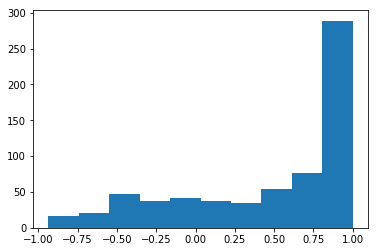

In [44]:
plt.hist(lmnop.Growth)
plt.show()

In [45]:
from importlib import reload

In [46]:
sns = reload(sns)

In [53]:
out_save = lmnop.iloc[:, :3]

In [57]:
out_save['UMAP_x'] = u_coords[:, 0]
out_save['UMAP_y'] = u_coords[:, 1]

NameError: name 'u_coords' is not defined

In [56]:
#out_save.to_csv('drugKinomeVectorEmbeddings.csv')
out_save = pd.read_csv('../results/drugKinomeVectorEmbeddings.csv', index_col=0)

In [58]:
out_save.head()

,Drug,Concentration,Average Growth,UMAP_x,UMAP_y
0,afatinib,0.003,0.894134,5.834625,-0.596999
1,afatinib,0.010,0.833127,5.960456,-3.142165
2,afatinib,0.030,0.761255,5.885349,-3.027888
3,afatinib,0.100,0.656311,5.912228,-3.126773
4,afatinib,0.300,0.504731,5.882901,-3.052478


In [59]:
u_coords = out_save[['UMAP_x', 'UMAP_y']].values

In [210]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [62]:
from sklearn.preprocessing import StandardScaler

In [203]:
for k in ['cosine', 'rbf', 'linear', 'sigmoid']:
    embed = KernelPCA(n_components=None, kernel=k, fit_inverse_transform=True)
    embed_coords = embed.fit_transform(StandardScaler().fit_transform(lmnop.iloc[:, 3:].values))
    print(k+' first 20 components:', np.sum((np.var(embed_coords, axis=0)/np.sum(np.var(embed_coords, axis=0)))[:20]))

cosine first 20 components: 0.5390954603856392
rbf first 20 components: 0.42600474173348657
linear first 20 components: 0.6177281660240183
sigmoid first 20 components: 0.6244670008932673


In [229]:
embed = KernelPCA(n_components=20, kernel='sigmoid', fit_inverse_transform=True)
embed_coords = embed.fit_transform(StandardScaler().fit_transform(lmnop.iloc[:, 3:].values))

In [230]:
embed_coords.shape

(656, 20)

In [249]:
def collect_GM_aic(i):
    mixture = GaussianMixture(n_components=i, covariance_type='full', n_init=10, max_iter=200)
    mixture.fit(embed_coords)
    return mixture.aic(embed_coords)

In [250]:
import multiprocessing as mp

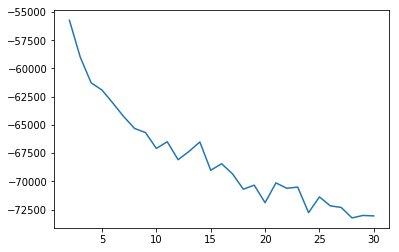

In [251]:
pool = mp.Pool(6)
GM_aics = pool.map(collect_GM_aic, range(2,31))
pool.close()

sns.lineplot(x=range(2,31), y=GM_aics)
plt.show()

In [83]:
embed = MDS(n_components=15)
u_coords = embed.fit_transform(StandardScaler().fit_transform(lmnop.iloc[:, 4:].values))
embed.stress_

363185.12101912516

In [85]:
print('Proportion of variance captured by the first 15 MDS Components:')
(np.var(u_coords, axis=0)/np.sum(np.var(u_coords, axis=0)))[:15]

Proportion of variance captured by the first 15 MDS Components:


array([0.06355827, 0.06237864, 0.06801891, 0.06466287, 0.06283085,
       0.07588517, 0.07601101, 0.05999747, 0.06046578, 0.08153864,
       0.0791337 , 0.06051223, 0.0605063 , 0.06289791, 0.06160224])

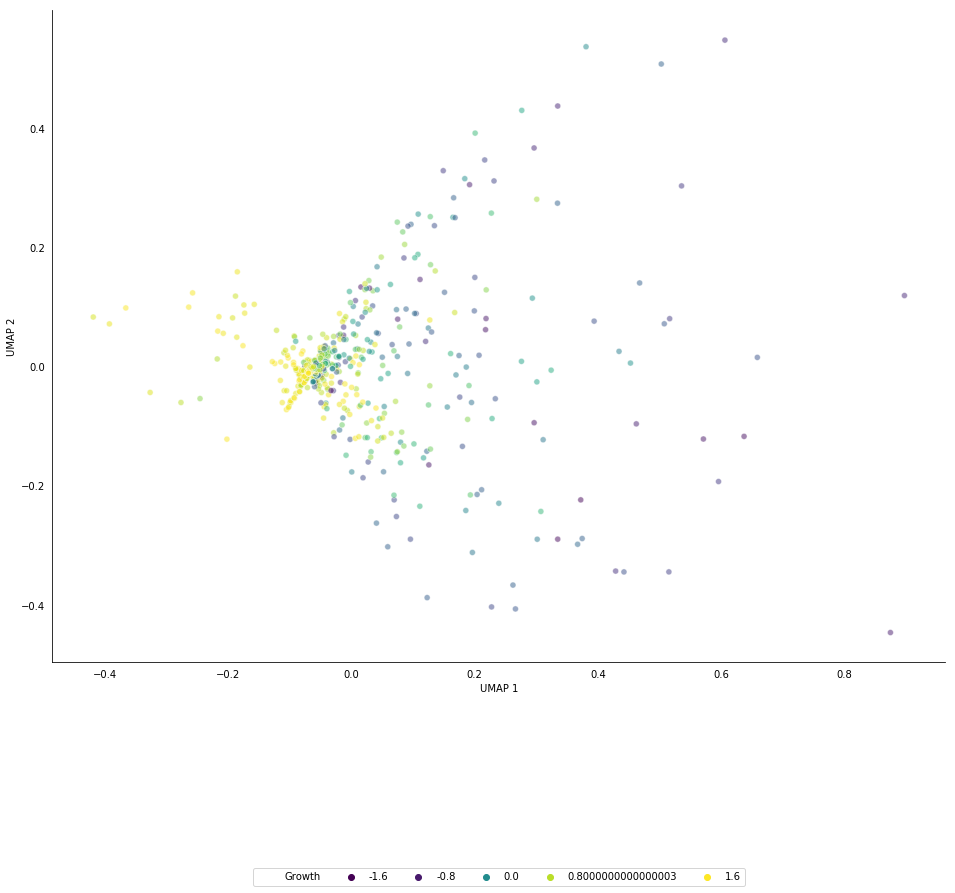

In [243]:
fig, ax = plt.subplots(figsize=(16,12))

#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=embed_coords[:, 0].tolist(), y=embed_coords[:, 1].tolist(), hue=lmnop.Growth, ax=ax, palette='viridis', vmax=1, vmin=-1, alpha=.5)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))
    
plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

In [77]:
lmnop.iloc[:, 4:].values.shape

(656, 232)

In [162]:
reg = SVR(kernel='rbf', gamma='scale')

grid_params = {'kernel':['rbf', 'linear', 'sigmoid', 'poly'],
               'C': [1e-3, 1e-2, 1e-1, 3e-1, 1e0, 3e0, 1e1]}

search = GridSearchCV(reg, 
                     grid_params, 
                     n_jobs=6, 
                     cv=5, 
                     iid=False)

#reg.fit(lmnop.iloc[:, 4:].values, out_save['Average Growth'])
search.fit(lmnop.iloc[:, 4:].values, np.arctanh(out_save['Average Growth']))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=6,
       param_grid={'kernel': ['rbf', 'linear', 'sigmoid', 'poly'], 'C': [0.001, 0.01, 0.1, 0.3, 1.0, 3.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [174]:
print(search.best_params_)
print(search.best_score_)

{'C': 3.0, 'kernel': 'rbf'}
0.3606648076811573


In [135]:
from sklearn.preprocessing import PowerTransformer

In [179]:
reg = SVR(kernel='rbf', gamma='scale', C=3.)
transformer = PowerTransformer()
transformer.fit(lmnop.iloc[:, 3:].values)

reg.fit(StandardScaler().fit_transform(lmnop.iloc[:, 3:].values), np.arctanh(out_save['Average Growth']))
reg.score(StandardScaler().fit_transform(lmnop.iloc[:, 3:].values), np.arctanh(out_save['Average Growth']))

0.684487115270151

In [138]:
from scipy.stats import pearsonr

In [187]:
pearsonr(np.tanh(reg.predict(StandardScaler().fit_transform(lmnop.iloc[:, 3:].values))), out_save['Average Growth'])

(0.8748534676861743, 4.657130310738217e-208)

In [334]:
from sklearn.neighbors import RadiusNeighborsRegressor

neighbors = RadiusNeighborsRegressor(weights='distance', n_jobs=2)
neighbors.fit(u_coords, lmnop.Growth.values)

RadiusNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=2, p=2, radius=1.0,
             weights='distance')

In [306]:
from sklearn.neighbors import KernelDensity

#epanechnikov_density = KernelDensity(kernel = 'epanechnikov')
gaussian_density = KernelDensity(kernel = 'gaussian')
#gaussian_density = GaussianMixture(n_components=28, n_init=10, max_iter=200)

#epanechnikov_density.fit(embed_coords)
gaussian_density.fit(StandardScaler().fit_transform(lmnop.iloc[:, 3:]))

#sample = gaussian_density.sample(n_samples=100000, random_state=1923)
#sample_likelihoods = np.exp(epanechnikov_density.score_samples(sample))
#keep_probability = np.random.uniform(size=100000)

#final_sample = sample[sample_likelihoods > keep_probability, :]
final_sample = gaussian_density.sample(n_samples=10000)#[0]

#remaining = final_sample.shape[0]
#print(remaining, 'samples from epanechnikov kernel kept.', str(remaining/100000.*100)+'% efficiency')

In [307]:
#inverted_samples = embed.inverse_transform(final_sample)
inverted_samples = final_sample

In [273]:
inverted_samples.shape

(2000, 233)

(array([ 10., 136., 337., 656., 624., 677., 754., 839., 670., 297.]),
 array([-0.76962968, -0.59728132, -0.42493296, -0.25258461, -0.08023625,
         0.09211211,  0.26446046,  0.43680882,  0.60915718,  0.78150554,
         0.95385389]),
 <a list of 10 Patch objects>)

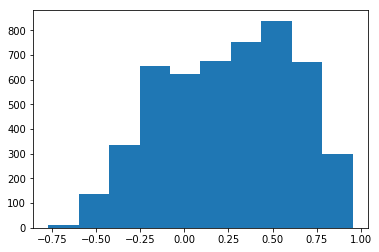

In [292]:
plt.hist(np.tanh(reg.predict(inverted_samples)))

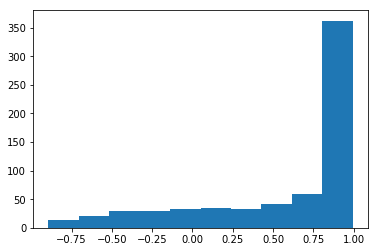

In [260]:
plt.hist(np.tanh(reg.predict(StandardScaler().fit_transform(lmnop.iloc[:, 3:].values))))
plt.show()

In [261]:
inverted_samples.shape

(2000, 233)

In [262]:
inverted_samples

array([[-0.01144812,  0.07251747,  0.0566612 , ..., -0.09956416,
         0.01130283,  0.05851541],
       [-0.00371591,  0.06248233,  0.04800641, ..., -0.09844225,
        -0.01080117,  0.04592125],
       [-0.08354881,  0.04169591,  0.01484141, ..., -0.14905745,
        -0.0055815 ,  0.03981202],
       ...,
       [-0.11877218, -0.15284051, -0.12647397, ..., -0.11529882,
        -0.07579525, -0.12481797],
       [-0.10604713, -0.02633271, -0.00399108, ..., -0.07081348,
        -0.01129504, -0.02575808],
       [-0.09552565, -0.16844732, -0.15462831, ..., -0.09816708,
        -0.04246069, -0.11098338]])

In [192]:
plt_embed = UMAP(n_components=2, metric='euclidean')
plt_coords = plt_embed.fit_transform(lmnop.iloc[:, 3:])

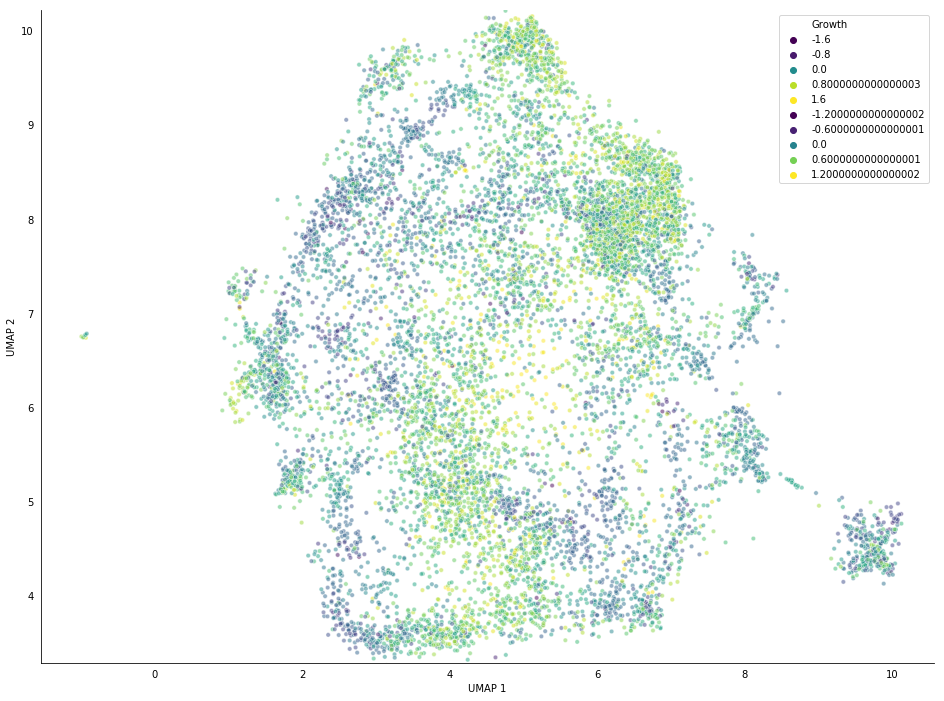

In [309]:
fig, ax = plt.subplots(figsize=(16,12))

#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x=plt_coords[:, 0].tolist(), y=plt_coords[:, 1].tolist(), hue=lmnop.Growth, ax=ax, palette='viridis', vmax=1, vmin=-1, alpha=.5, s=20)

x_lims = ax.get_xlim()
y_lims = ax.get_ylim()
    
scaler = StandardScaler()
scaler.fit(lmnop.iloc[:, 3:].values)

sample_preds = np.tanh(reg.predict(inverted_samples))

sample_plt_coords = plt_embed.transform(inverted_samples)

sns.scatterplot(x=sample_plt_coords[:, 0].tolist(), y=sample_plt_coords[:, 1].tolist(), hue=sample_preds, ax=ax, palette='viridis', vmax=1, vmin=-1, alpha=.5, s=20)

ax.set_xlim(x_lims)
ax.set_ylim(y_lims)

plt.tick_params(axis='x', which='both', bottom=False, top=False)
plt.tick_params(axis='y', which='both', right=False, left=False)

for pos in ['right','top']:
    plt.gca().spines[pos].set_visible(False)
    
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

#for i, row in plot_text.iterrows():
#    plt.annotate(row.name, (row[0], row[1]))
    
#plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)

plt.show()

In [302]:
out_new = pd.DataFrame(list(zip(['imputed'] * len(sample_preds), ['na'] * len(sample_preds), sample_preds, final_sample[:, 0], final_sample[:, 1])), columns=out_save.columns)



In [283]:
out_new.head()

,Drug,Concentration,Average Growth,UMAP_x,UMAP_y
0,imputed,na,-0.091781,-0.441227,-0.858757
1,imputed,na,0.471480,-1.081018,-1.444841
2,imputed,na,-0.220772,-0.148658,0.843989
3,imputed,na,0.549723,1.141811,-1.718211
4,imputed,na,0.366304,1.562275,0.186186


In [303]:
out_final = pd.concat([out_save, out_new], ignore_index=True)

In [285]:
#out_final.to_csv('../results/imputed_and_original_KinomeVectorEmbeddings.csv')
out_final = pd.read_csv('../results/imputed_and_original_KinomeVectorEmbeddings.csv')

In [288]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


In [263]:
%matplotlib inline

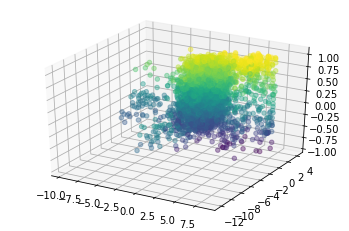

In [305]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(out_final['UMAP_x'], out_final['UMAP_y'], out_final['Average Growth'], c=out_final['Average Growth'], cmap='viridis', alpha=0.4)

plt.show()

In [311]:
t.columns

Index(['Drug', 'Cellline', 'Growth', 'Concentration', 'AAK1', 'ABL1', 'ABL2',
       'ACVR1', 'ACVR1B', 'ACVR2B',
       ...
       'TGFBR2', 'TNIK', 'TNK1', 'TNK2', 'TP53RK', 'TTK', 'TYK2', 'ULK1',
       'WEE1', 'YES1'],
      dtype='object', length=237)

In [329]:
louv_map = dict(louv.cluster_sub)
grps = [louv_map[x] for x in t.columns[4:]]
grp_perturbations = t.groupby(['Drug', 'Concentration']).agg(np.mean) # remove multiple cell lines
grp_perturbations = grp_perturbations.reset_index().iloc[:, 3:] * kin_standard_dev# slice to kinases
grp_perturbations = grp_perturbations.values.T # transpose for a groupby
grp_perturbations = pd.DataFrame(grp_perturbations)
grp_perturbations['group'] = grps

# apply norm to control for variable sizes
grp_perturbations = grp_perturbations.groupby('group').agg(np.linalg.norm).T

# anscombe transform
#grp_perturbations = 2*np.sqrt(grp_perturbations + .375)

In [321]:
grp_perturbations.shape

(656, 18)

In [326]:
grp_perturbations -= np.min(grp_perturbations.values)

(array([479.,  21.,  83.,  35.,  23.,   8.,   2.,   2.,   0.,   3.]),
 array([ 0.        ,  4.28659797,  8.57319593, 12.8597939 , 17.14639186,
        21.43298983, 25.7195878 , 30.00618576, 34.29278373, 38.5793817 ,
        42.86597966]),
 <a list of 10 Patch objects>)

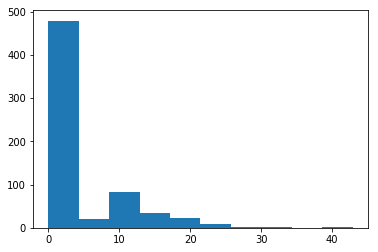

In [330]:
plt.hist(grp_perturbations.iloc[:, 10])

In [328]:
np.max(grp_perturbations.values)

42.86597966181427

In [332]:
levels=list(np.unique(np.percentile(grp_perturbations, [0,15,30,45,55,65,75,80,85,90,95,99,100])))
levels

[0.0,
 0.018584341107495808,
 0.42362187815753083,
 0.687501309479189,
 1.1891820564922615,
 2.579476528066835,
 12.050883845850642,
 21.08367411649759,
 42.86597966181427]

In [338]:
def get_grid_input(lims):
    return np.arange(lims[0], lims[1], (lims[1] - lims[0])/50)

# create a meshgrid to contour
cntr_x, cntr_y = np.meshgrid(get_grid_input(x_lims), get_grid_input(y_lims))

# fill the contours with model prediction
grid_X = np.array(list(zip(cntr_x.flatten(), cntr_y.flatten())))
#grid_X = plt_embed.inverse_transform(np.array(list(zip(cntr_x.flatten(), cntr_y.flatten()))))

ZeroDivisionError: division by zero

In [ ]:
gaussian_density.score()

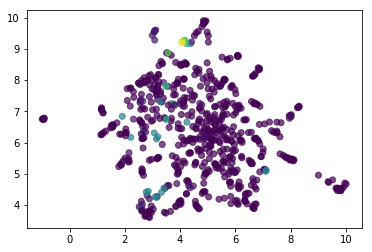

In [486]:
plt.scatter(plt_coords[:, 0], plt_coords[:, 1], c=grp_perturbations.iloc[:, 4], alpha=0.7)
plt.show()

In [366]:
cntr_x, cntr_y = np.meshgrid(get_grid_input(x_lims), get_grid_input(y_lims))

# fill the contours with model prediction
cntr_z = reg.predict(np.array(list(zip(cntr_x.flatten(), cntr_y.flatten()))))
cntr_z = cntr_z.reshape(cntr_x.shape)

/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


In [459]:
def mindist(ref, point):
    return np.min(np.linalg.norm(ref - point, axis=1))
    

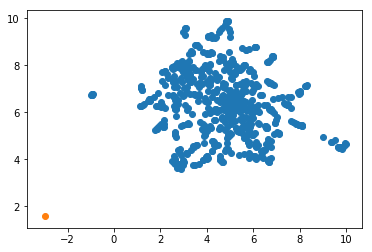

In [419]:
plt.scatter(plt_coords[:, 0], plt_coords[:, 1])
plt.scatter(-2.98901629447937, 1.6028704643249512)

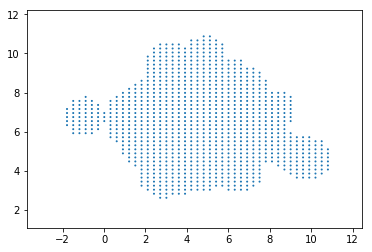

In [474]:
plt.scatter(cntr_x.flatten(), cntr_y.flatten(), s=[mindist(plt_coords, p)<1. for p in list(zip(cntr_x.flatten(), cntr_y.flatten()))])

/Users/isrobson/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


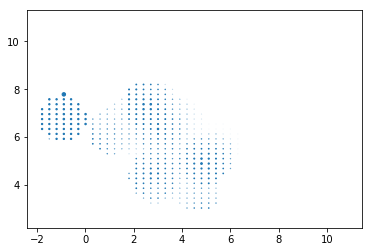

In [493]:
plt.scatter(cntr_x.flatten(), cntr_y.flatten(), s=cntr_z)

In [485]:
np.sum(cntr_z == .001)

0

(array([1512.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         988.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

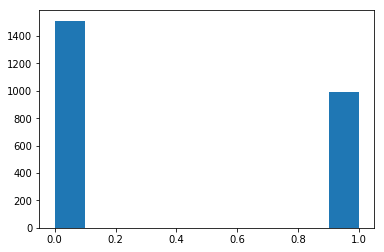

In [483]:
plt.hist(min_vals.flatten())

/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/isrobson/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have

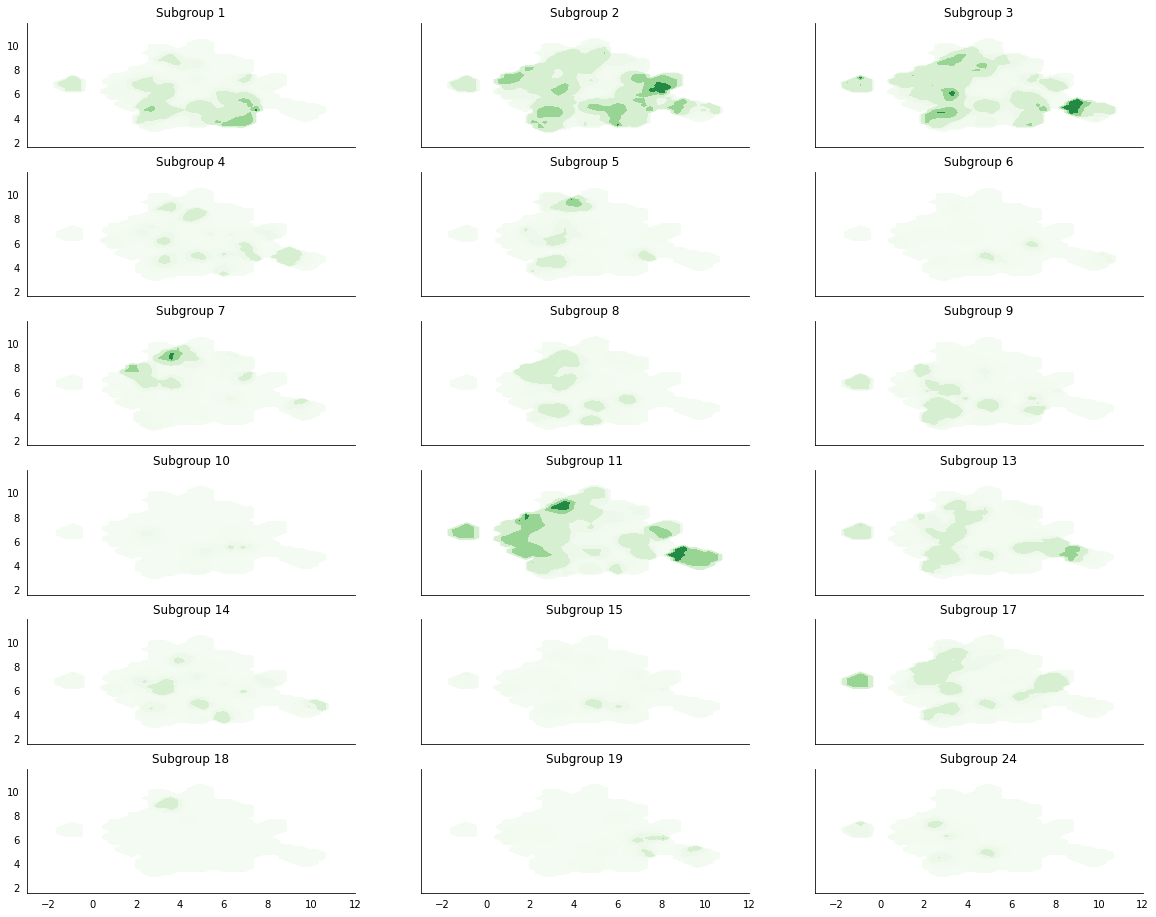

In [508]:
fig, axes = plt.subplots(figsize=(20,16), ncols=3, nrows=6, sharex=True, sharey=True)

radius = .6
levels=[-.5,-.25]+list(np.unique(np.percentile(grp_perturbations, [0,15,30,45,55,65,75,80,85,90,95,99,100])))

x_lims = (np.min(plt_coords[:, 0])-2, np.max(plt_coords[:, 0])+2)
y_lims = (np.min(plt_coords[:, 1])-2, np.max(plt_coords[:, 1])+2)

# create a meshgrid to contour
cntr_x, cntr_y = np.meshgrid(get_grid_input(x_lims), get_grid_input(y_lims))
min_vals = np.array([(mindist(plt_coords, p)>radius)*-.5 for p in list(zip(cntr_x.flatten(), cntr_y.flatten()))]).reshape(cntr_x.shape)

for k in range(len(np.unique(grps))):
    #print(k, k//6, k%3)
    ax = axes[k//3, k%3]
    #cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
    #sns.scatterplot(x=u_coords[:, 0].tolist(), y=u_coords[:, 1].tolist(), hue=grp_perturbations.iloc[:, k].values, ax=ax, palette='viridis', vmax=7, vmin=0, alpha=.0, legend=False)

    reg = RadiusNeighborsRegressor(radius=radius, weights='distance', n_jobs=2)
    reg.fit(plt_coords, grp_perturbations.iloc[:, k].values)

    #reg_preds = reg.predict(final_sample)

    #sns.scatterplot(x=final_sample[:, 0].tolist(), y=final_sample[:, 1].tolist(), hue=reg_preds, ax=ax, palette='viridis', vmax=7, vmin=0, alpha=0, legend=False)

    #levels=[0, .5, 1, 1.5, 2, 3, 5, 6]
    #levels=list(np.unique(np.percentile(grp_perturbations.iloc[:, k], [0,15,30,45,55,65,75,80,85,90,95,99,100])))

    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)

    def get_grid_input(lims):
        return np.arange(lims[0], lims[1], (lims[1] - lims[0])/50)

    # fill the contours with model prediction
    cntr_z = reg.predict(np.array(list(zip(cntr_x.flatten(), cntr_y.flatten()))))
    cntr_z = cntr_z.reshape(cntr_x.shape)
    
    '''fill_values = []
    
    for nan_point in list(zip(cntr_x[np.isnan(cntr_z)].flatten(), cntr_y[np.isnan(cntr_z)].flatten())):
        #print(nan_point)
        if mindist(plt_coords, nan_point) < 1.:
            fill_values.append(.001)
        else:
            fill_values.append(0)'''
            
    #display(cntr_z)
    #print(np.sum(cntr_z == 0))
    
    #cntr_z[np.isnan(cntr_z)] = np.array(fill_values)
    cntr_z[np.isnan(cntr_z)] = min_vals[np.isnan(cntr_z)]
    
    #print(np.sum(cntr_z == 0))
    #display(np.array(fill_values))
    #display(cntr_z)
    
    
    cntr = ax.contourf(cntr_x,cntr_y,cntr_z,levels[1:],cmap='Greens', alpha = 1, extend='max', vmin=-1) 
    
    #print(cntr.levels)
    #plt.clabel(cntr,[0.],fmt='%f')
    #plt.clabel(cntr,fmt='%f')

    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False, left=False)

    for pos in ['right','top']:
        ax.spines[pos].set_visible(False)

    #plt.xlabel('UMAP 1')
    #plt.ylabel('UMAP 2')

    #for i, row in plot_text.iterrows():
    #    plt.annotate(row.name, (row[0], row[1]))

    #plt.legend(bbox_to_anchor=(.5, -.35), loc=8, ncol=8)
    
    ax.set_title('Subgroup ' + str(np.unique(grps)[k]))
  

plt.show()

In [492]:
levels

[-0.5,
 0.0,
 0.018584341107495808,
 0.42362187815753083,
 0.687501309479189,
 1.1891820564922615,
 2.579476528066835,
 12.050883845850642,
 21.08367411649759,
 42.86597966181427]